# Build Model

### Import

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
def wrangle(file_path):
    df = pd.read_csv(file_path)
    # drop columns which are not useful in the model
    df = df.drop(columns=['year', 'uniqueid'])
    
    """ Encoding Categorical Features """
    # Identify columns with categorical values for encoding
    categorical_columns = [x for x in df.columns if type(df[x][1]) == str]
    print(categorical_columns)
    print(f"Our dataframe has {len(categorical_columns)} categorical columns")

    # Instantiate label encoder
    label_encoder = LabelEncoder()

    # Transform data
    for column in df.columns:
      df[column] = label_encoder.fit_transform(df[column])

    return df

In [20]:
# data = wrangle("Train.csv")
data = wrangle("/content/drive/MyDrive/Financial Inclusion in Africa/Train.csv") ## when file is in drive
print(data.shape)
data.head()

['country', 'bank_account', 'location_type', 'cellphone_access', 'gender_of_respondent', 'relationship_with_head', 'marital_status', 'education_level', 'job_type']
Our dataframe has 9 categorical columns
(23524, 11)


,country,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,0,1,0,1,2,8,0,5,2,3,9
1,0,0,0,0,4,54,0,1,4,0,4
2,0,1,1,1,4,10,1,3,3,5,9
3,0,0,0,1,4,18,0,1,2,2,3
4,0,0,1,0,7,10,1,0,3,2,5


## Split
Feature matrix and Target Vector


In [21]:
target = "bank_account"
X= data.drop(columns=target)
y = data[target]
print(X.shape)
print(y.shape)

(23524, 10)
(23524,)


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (18819, 10)
y_train shape: (18819,)
X_test shape: (4705, 10)
y_test shape: (4705,)


## Resample Data
We will use **Oversampling** since we had an imbalanced class of target vector

In [23]:
# Instantiate RandomOverSampler
over_sampler = RandomOverSampler(random_state=42)

X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
print(X_train_over.shape)

(32298, 10)


## Build Model

### Baseline

In [24]:
baseline_accuracy = y_train.value_counts(normalize=True).max()
baseline_accuracy

0.858122110632871

### Iterate

In [25]:
# Instantiate "classifier" as "clf"
clf = RandomForestClassifier(random_state=42)

# Perform cross-validation with your classifier, using the over-sampled training data.
# We want five folds, so set cv to 5.
# We also want to speed up training, to set n_jobs to -1
cv_acc_scores = cross_val_score(clf, X_train_over, y_train_over, cv=5, n_jobs=-1)
print(cv_acc_scores)

# The above step is not important

[0.93173375 0.93405573 0.9371517  0.9304846  0.931878  ]


In [39]:
# Instantiate "classifier" as "clf" (could be a pipeline)
clf = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(random_state=42)
    )

# Define a hyperparameter grid for model tuning
params = {
    "randomforestclassifier__n_estimators": range(25, 100, 10),
    "randomforestclassifier__max_depth": range(10, 50, 5)
}
params

{'randomforestclassifier__n_estimators': range(25, 100, 10),
 'randomforestclassifier__max_depth': range(10, 50, 5)}

Perform a hyperparameter grid search

In [40]:
model = GridSearchCV(
    clf,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1
)
model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 5),
                         'randomforestclassifier__n_estimators': range(25, 100, 10)},
             verbose=1)

In [41]:
# Train Model
model.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 5),
                         'randomforestclassifier__n_estimators': range(25, 100, 10)},
             verbose=1)

In [42]:
model.best_params_

{'randomforestclassifier__max_depth': 25,
 'randomforestclassifier__n_estimators': 75}

## Evaluate

In [43]:
train_accuracy = model.score(X_train, y_train)
test_accuracy = model.score(X_test, y_test)

print("Training Accuracy:", round(train_accuracy, 4))
print("Test Accuracy:", round(test_accuracy, 4))

Training Accuracy: 0.9692
Test Accuracy: 0.8357


**Our model performed poorly than the baseline**

Next we are going to look at how the model actually performed by looking at the numbers

In [44]:
# calculate how many values belong to the positive and negative classes
y_test.value_counts()

0    4063
1     642
Name: bank_account, dtype: int64

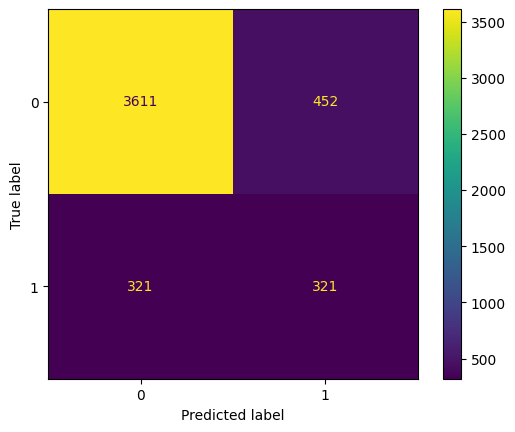

In [45]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test);

 If you sum the values in the bottom row, you get the total number of positive observations in y_test (321+321=642). And the top row sum to the number of negative observations (3611+452=4063).

## Results Communication

In [12]:
# Get feature names
features = model.feature_names_in_
features

array(['country', 'location_type', 'cellphone_access', 'household_size',
       'age_of_respondent', 'gender_of_respondent',
       'relationship_with_head', 'marital_status', 'education_level',
       'job_type'], dtype=object)

In [13]:
# Extract importances from model
importances = model.best_estimator_.feature_importances_
importances

array([0.07229336, 0.03201309, 0.08629163, 0.12714428, 0.30778783,
       0.02345393, 0.03611976, 0.03815617, 0.18118438, 0.09555557])

In [14]:
# Series with feature names and importances
feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp

gender_of_respondent      0.023454
location_type             0.032013
relationship_with_head    0.036120
marital_status            0.038156
country                   0.072293
cellphone_access          0.086292
job_type                  0.095556
household_size            0.127144
education_level           0.181184
age_of_respondent         0.307788
dtype: float64

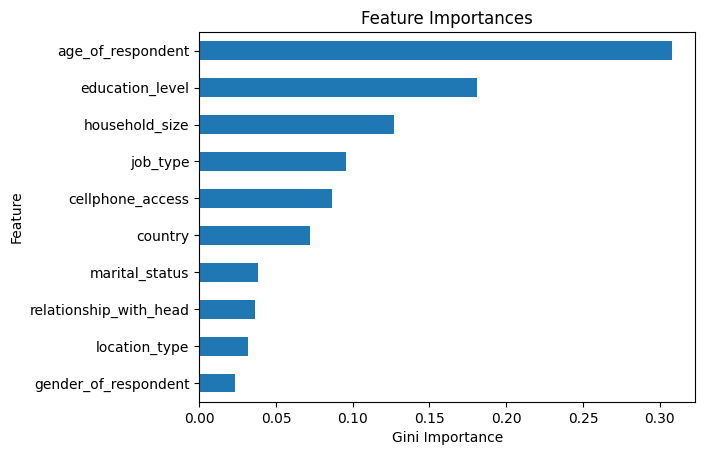

In [15]:
# Plot important features
feat_imp.plot(kind='barh')
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Feature Importances");